https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [1]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as ts
from math import gcd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

In [3]:
dataset=pd.read_csv("Shampoo.csv", date_parser=parser,parse_dates=[0])
display(dataset)

C:\Users\dogan\AppData\Local\Temp\ipykernel_12828\4175343489.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime('190'+x, '%Y-%m')


,Month,Sales
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


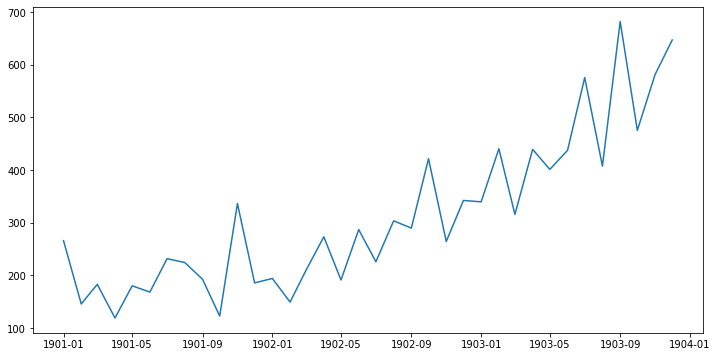

In [4]:
plt.figure(figsize=(12,6))
plt.plot(dataset["Month"].values, dataset["Sales"].values)

In [5]:
def timeseries_to_supervised(df,n_in, n_out):
    cols = list()
    names = list()
    for i in range(n_in,0,-1):
        cols.append(df["Sales"].shift(i))
        names += [("Sales(t-%d)"%(i))]
    for i in range(n_out):
        cols.append(df["Sales"].shift(-i))
        if i == 0:
            names += [("Sales(t)")]
        else:
            names += [("Sales(t+%d)"%(i))]
#     print(cols)
#     print(names)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg["Month"] = df["Month"]
    agg.dropna(inplace=True)
    return agg
    

In [6]:
window = 5
n_months = 2
n_features = 1
df = timeseries_to_supervised(dataset, window, n_months)
# display(df)

In [7]:
df.set_index("Month",inplace=True)

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

In [8]:
# scaler = MinMaxScaler(feature_range=(-1,1))
# scaler = scaler.fit(df.values)
# data_sc = scaler.transform(df.values)



In [9]:
def scaled_transform(X,min_data, max_data, min_range, max_range):
    X_std = (X-min_data)/(max_data-min_data)
    X_sc = X_std * (max_range - min_range) + (min_range)
    return np.array(X_sc)

In [10]:
# apply MinMaxScaler with feature range(-1,1)
min_range = -1
max_range = 1
min_data = df.values.min()
max_data = df.values.max()
print(min_data,max_data)
data_sc = scaled_transform(df,min_data, max_data, min_range, max_range)

119.3 682.0


In [11]:
print(data_sc)

[[-0.47858539 -0.90545584 -0.77323618 -1.         -0.7831882  -0.82512884
  -0.60014217]
 [-0.90545584 -0.77323618 -1.         -0.7831882  -0.82512884 -0.60014217
  -0.6260885 ]
 [-0.77323618 -1.         -0.7831882  -0.82512884 -0.60014217 -0.6260885
  -0.73875955]
 [-1.         -0.7831882  -0.82512884 -0.60014217 -0.6260885  -0.73875955
  -0.98720455]
 [-0.7831882  -0.82512884 -0.60014217 -0.6260885  -0.73875955 -0.98720455
  -0.22800782]
 [-0.82512884 -0.60014217 -0.6260885  -0.73875955 -0.98720455 -0.22800782
  -0.76328417]
 [-0.60014217 -0.6260885  -0.73875955 -0.98720455 -0.22800782 -0.76328417
  -0.73342811]
 [-0.6260885  -0.73875955 -0.98720455 -0.22800782 -0.76328417 -0.73342811
  -0.89266039]
 [-0.73875955 -0.98720455 -0.22800782 -0.76328417 -0.73342811 -0.89266039
  -0.6772703 ]
 [-0.98720455 -0.22800782 -0.76328417 -0.73342811 -0.89266039 -0.6772703
  -0.45263906]
 [-0.22800782 -0.76328417 -0.73342811 -0.89266039 -0.6772703  -0.45263906
  -0.74373556]
 [-0.76328417 -0.733428

In [12]:
print(df.values)

[[266.  145.9 183.1 119.3 180.3 168.5 231.8]
 [145.9 183.1 119.3 180.3 168.5 231.8 224.5]
 [183.1 119.3 180.3 168.5 231.8 224.5 192.8]
 [119.3 180.3 168.5 231.8 224.5 192.8 122.9]
 [180.3 168.5 231.8 224.5 192.8 122.9 336.5]
 [168.5 231.8 224.5 192.8 122.9 336.5 185.9]
 [231.8 224.5 192.8 122.9 336.5 185.9 194.3]
 [224.5 192.8 122.9 336.5 185.9 194.3 149.5]
 [192.8 122.9 336.5 185.9 194.3 149.5 210.1]
 [122.9 336.5 185.9 194.3 149.5 210.1 273.3]
 [336.5 185.9 194.3 149.5 210.1 273.3 191.4]
 [185.9 194.3 149.5 210.1 273.3 191.4 287. ]
 [194.3 149.5 210.1 273.3 191.4 287.  226. ]
 [149.5 210.1 273.3 191.4 287.  226.  303.6]
 [210.1 273.3 191.4 287.  226.  303.6 289.9]
 [273.3 191.4 287.  226.  303.6 289.9 421.6]
 [191.4 287.  226.  303.6 289.9 421.6 264.5]
 [287.  226.  303.6 289.9 421.6 264.5 342.3]
 [226.  303.6 289.9 421.6 264.5 342.3 339.7]
 [303.6 289.9 421.6 264.5 342.3 339.7 440.4]
 [289.9 421.6 264.5 342.3 339.7 440.4 315.9]
 [421.6 264.5 342.3 339.7 440.4 315.9 439.3]
 [264.5 34

In [13]:
train, test = data_sc[:-12,:], data_sc[-12:,:]
X_train, y_train = train[:,:-n_months], train[:,-n_months:]
X_test, y_test = test[:,:-n_months], test[:,-n_months:]

# reshape for LSTM
X_train = X_train.reshape(X_train.shape[0],window,n_features)
X_test = X_test.reshape(X_test.shape[0],window,n_features)

# batch_size = gcd(X_train.shape[0],X_test.shape[0])
batch_size = 1
print(batch_size)

1


In [14]:
print("X train")
print(X_train)
print("y train")
print(y_train)
print("X test")
print(X_test)
print("y test")
print(y_test)

X train
[[[-0.47858539]
  [-0.90545584]
  [-0.77323618]
  [-1.        ]
  [-0.7831882 ]]

 [[-0.90545584]
  [-0.77323618]
  [-1.        ]
  [-0.7831882 ]
  [-0.82512884]]

 [[-0.77323618]
  [-1.        ]
  [-0.7831882 ]
  [-0.82512884]
  [-0.60014217]]

 [[-1.        ]
  [-0.7831882 ]
  [-0.82512884]
  [-0.60014217]
  [-0.6260885 ]]

 [[-0.7831882 ]
  [-0.82512884]
  [-0.60014217]
  [-0.6260885 ]
  [-0.73875955]]

 [[-0.82512884]
  [-0.60014217]
  [-0.6260885 ]
  [-0.73875955]
  [-0.98720455]]

 [[-0.60014217]
  [-0.6260885 ]
  [-0.73875955]
  [-0.98720455]
  [-0.22800782]]

 [[-0.6260885 ]
  [-0.73875955]
  [-0.98720455]
  [-0.22800782]
  [-0.76328417]]

 [[-0.73875955]
  [-0.98720455]
  [-0.22800782]
  [-0.76328417]
  [-0.73342811]]

 [[-0.98720455]
  [-0.22800782]
  [-0.76328417]
  [-0.73342811]
  [-0.89266039]]

 [[-0.22800782]
  [-0.76328417]
  [-0.73342811]
  [-0.89266039]
  [-0.6772703 ]]

 [[-0.76328417]
  [-0.73342811]
  [-0.89266039]
  [-0.6772703 ]
  [-0.45263906]]

 [[-0.73

In [15]:
model = Sequential()
model.add(LSTM(1,batch_size=(batch_size,window,n_features),stateful=True))
model.add(Dense(n_months))
model.compile(optimizer="adam",loss="mean_squared_error")

In [16]:

model.fit(X_train,y_train,epochs=1000, batch_size=batch_size,verbose=2,shuffle=False)
   

Epoch 1/1000
18/18 - 4s - loss: 0.3755 - 4s/epoch - 213ms/step
Epoch 2/1000
18/18 - 0s - loss: 0.3575 - 78ms/epoch - 4ms/step
Epoch 3/1000
18/18 - 0s - loss: 0.3406 - 78ms/epoch - 4ms/step
Epoch 4/1000
18/18 - 0s - loss: 0.3246 - 94ms/epoch - 5ms/step
Epoch 5/1000
18/18 - 0s - loss: 0.3092 - 85ms/epoch - 5ms/step
Epoch 6/1000
18/18 - 0s - loss: 0.2946 - 71ms/epoch - 4ms/step
Epoch 7/1000
18/18 - 0s - loss: 0.2807 - 81ms/epoch - 5ms/step
Epoch 8/1000
18/18 - 0s - loss: 0.2674 - 78ms/epoch - 4ms/step
Epoch 9/1000
18/18 - 0s - loss: 0.2548 - 84ms/epoch - 5ms/step
Epoch 10/1000
18/18 - 0s - loss: 0.2427 - 78ms/epoch - 4ms/step
Epoch 11/1000
18/18 - 0s - loss: 0.2311 - 78ms/epoch - 4ms/step
Epoch 12/1000
18/18 - 0s - loss: 0.2196 - 80ms/epoch - 4ms/step
Epoch 13/1000
18/18 - 0s - loss: 0.2078 - 78ms/epoch - 4ms/step
Epoch 14/1000
18/18 - 0s - loss: 0.1952 - 78ms/epoch - 4ms/step
Epoch 15/1000
18/18 - 0s - loss: 0.1815 - 78ms/epoch - 4ms/step
Epoch 16/1000
18/18 - 0s - loss: 0.1667 - 78ms/ep

Epoch 129/1000
18/18 - 0s - loss: 0.0614 - 95ms/epoch - 5ms/step
Epoch 130/1000
18/18 - 0s - loss: 0.0613 - 68ms/epoch - 4ms/step
Epoch 131/1000
18/18 - 0s - loss: 0.0612 - 78ms/epoch - 4ms/step
Epoch 132/1000
18/18 - 0s - loss: 0.0611 - 78ms/epoch - 4ms/step
Epoch 133/1000
18/18 - 0s - loss: 0.0611 - 94ms/epoch - 5ms/step
Epoch 134/1000
18/18 - 0s - loss: 0.0610 - 78ms/epoch - 4ms/step
Epoch 135/1000
18/18 - 0s - loss: 0.0609 - 94ms/epoch - 5ms/step
Epoch 136/1000
18/18 - 0s - loss: 0.0608 - 78ms/epoch - 4ms/step
Epoch 137/1000
18/18 - 0s - loss: 0.0608 - 78ms/epoch - 4ms/step
Epoch 138/1000
18/18 - 0s - loss: 0.0607 - 78ms/epoch - 4ms/step
Epoch 139/1000
18/18 - 0s - loss: 0.0606 - 78ms/epoch - 4ms/step
Epoch 140/1000
18/18 - 0s - loss: 0.0605 - 78ms/epoch - 4ms/step
Epoch 141/1000
18/18 - 0s - loss: 0.0605 - 78ms/epoch - 4ms/step
Epoch 142/1000
18/18 - 0s - loss: 0.0604 - 94ms/epoch - 5ms/step
Epoch 143/1000
18/18 - 0s - loss: 0.0603 - 78ms/epoch - 4ms/step
Epoch 144/1000
18/18 - 0s

18/18 - 0s - loss: 0.0533 - 78ms/epoch - 4ms/step
Epoch 256/1000
18/18 - 0s - loss: 0.0532 - 78ms/epoch - 4ms/step
Epoch 257/1000
18/18 - 0s - loss: 0.0531 - 78ms/epoch - 4ms/step
Epoch 258/1000
18/18 - 0s - loss: 0.0531 - 78ms/epoch - 4ms/step
Epoch 259/1000
18/18 - 0s - loss: 0.0530 - 94ms/epoch - 5ms/step
Epoch 260/1000
18/18 - 0s - loss: 0.0530 - 78ms/epoch - 4ms/step
Epoch 261/1000
18/18 - 0s - loss: 0.0529 - 94ms/epoch - 5ms/step
Epoch 262/1000
18/18 - 0s - loss: 0.0529 - 78ms/epoch - 4ms/step
Epoch 263/1000
18/18 - 0s - loss: 0.0528 - 78ms/epoch - 4ms/step
Epoch 264/1000
18/18 - 0s - loss: 0.0528 - 78ms/epoch - 4ms/step
Epoch 265/1000
18/18 - 0s - loss: 0.0527 - 78ms/epoch - 4ms/step
Epoch 266/1000
18/18 - 0s - loss: 0.0526 - 94ms/epoch - 5ms/step
Epoch 267/1000
18/18 - 0s - loss: 0.0526 - 78ms/epoch - 4ms/step
Epoch 268/1000
18/18 - 0s - loss: 0.0525 - 78ms/epoch - 4ms/step
Epoch 269/1000
18/18 - 0s - loss: 0.0525 - 78ms/epoch - 4ms/step
Epoch 270/1000
18/18 - 0s - loss: 0.0524

Epoch 382/1000
18/18 - 0s - loss: 0.0479 - 78ms/epoch - 4ms/step
Epoch 383/1000
18/18 - 0s - loss: 0.0478 - 78ms/epoch - 4ms/step
Epoch 384/1000
18/18 - 0s - loss: 0.0478 - 94ms/epoch - 5ms/step
Epoch 385/1000
18/18 - 0s - loss: 0.0478 - 76ms/epoch - 4ms/step
Epoch 386/1000
18/18 - 0s - loss: 0.0478 - 94ms/epoch - 5ms/step
Epoch 387/1000
18/18 - 0s - loss: 0.0477 - 78ms/epoch - 4ms/step
Epoch 388/1000
18/18 - 0s - loss: 0.0477 - 94ms/epoch - 5ms/step
Epoch 389/1000
18/18 - 0s - loss: 0.0477 - 78ms/epoch - 4ms/step
Epoch 390/1000
18/18 - 0s - loss: 0.0477 - 78ms/epoch - 4ms/step
Epoch 391/1000
18/18 - 0s - loss: 0.0477 - 78ms/epoch - 4ms/step
Epoch 392/1000
18/18 - 0s - loss: 0.0476 - 78ms/epoch - 4ms/step
Epoch 393/1000
18/18 - 0s - loss: 0.0476 - 94ms/epoch - 5ms/step
Epoch 394/1000
18/18 - 0s - loss: 0.0476 - 78ms/epoch - 4ms/step
Epoch 395/1000
18/18 - 0s - loss: 0.0476 - 84ms/epoch - 5ms/step
Epoch 396/1000
18/18 - 0s - loss: 0.0476 - 78ms/epoch - 4ms/step
Epoch 397/1000
18/18 - 0s

18/18 - 0s - loss: 0.0464 - 78ms/epoch - 4ms/step
Epoch 509/1000
18/18 - 0s - loss: 0.0464 - 94ms/epoch - 5ms/step
Epoch 510/1000
18/18 - 0s - loss: 0.0464 - 78ms/epoch - 4ms/step
Epoch 511/1000
18/18 - 0s - loss: 0.0464 - 78ms/epoch - 4ms/step
Epoch 512/1000
18/18 - 0s - loss: 0.0464 - 78ms/epoch - 4ms/step
Epoch 513/1000
18/18 - 0s - loss: 0.0464 - 78ms/epoch - 4ms/step
Epoch 514/1000
18/18 - 0s - loss: 0.0464 - 94ms/epoch - 5ms/step
Epoch 515/1000
18/18 - 0s - loss: 0.0464 - 78ms/epoch - 4ms/step
Epoch 516/1000
18/18 - 0s - loss: 0.0463 - 94ms/epoch - 5ms/step
Epoch 517/1000
18/18 - 0s - loss: 0.0463 - 78ms/epoch - 4ms/step
Epoch 518/1000
18/18 - 0s - loss: 0.0463 - 94ms/epoch - 5ms/step
Epoch 519/1000
18/18 - 0s - loss: 0.0463 - 78ms/epoch - 4ms/step
Epoch 520/1000
18/18 - 0s - loss: 0.0463 - 78ms/epoch - 4ms/step
Epoch 521/1000
18/18 - 0s - loss: 0.0463 - 78ms/epoch - 4ms/step
Epoch 522/1000
18/18 - 0s - loss: 0.0463 - 78ms/epoch - 4ms/step
Epoch 523/1000
18/18 - 0s - loss: 0.0463

Epoch 635/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 636/1000
18/18 - 0s - loss: 0.0456 - 94ms/epoch - 5ms/step
Epoch 637/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 638/1000
18/18 - 0s - loss: 0.0456 - 94ms/epoch - 5ms/step
Epoch 639/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 640/1000
18/18 - 0s - loss: 0.0456 - 94ms/epoch - 5ms/step
Epoch 641/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 642/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 643/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 644/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 645/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 646/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 647/1000
18/18 - 0s - loss: 0.0456 - 94ms/epoch - 5ms/step
Epoch 648/1000
18/18 - 0s - loss: 0.0456 - 78ms/epoch - 4ms/step
Epoch 649/1000
18/18 - 0s - loss: 0.0456 - 94ms/epoch - 5ms/step
Epoch 650/1000
18/18 - 0s

18/18 - 0s - loss: 0.0449 - 78ms/epoch - 4ms/step
Epoch 762/1000
18/18 - 0s - loss: 0.0449 - 78ms/epoch - 4ms/step
Epoch 763/1000
18/18 - 0s - loss: 0.0449 - 78ms/epoch - 4ms/step
Epoch 764/1000
18/18 - 0s - loss: 0.0448 - 84ms/epoch - 5ms/step
Epoch 765/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 766/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 767/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 768/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 769/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 770/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 771/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 772/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 773/1000
18/18 - 0s - loss: 0.0448 - 94ms/epoch - 5ms/step
Epoch 774/1000
18/18 - 0s - loss: 0.0448 - 78ms/epoch - 4ms/step
Epoch 775/1000
18/18 - 0s - loss: 0.0448 - 93ms/epoch - 5ms/step
Epoch 776/1000
18/18 - 0s - loss: 0.0448

Epoch 888/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 889/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 890/1000
18/18 - 0s - loss: 0.0440 - 94ms/epoch - 5ms/step
Epoch 891/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 892/1000
18/18 - 0s - loss: 0.0440 - 94ms/epoch - 5ms/step
Epoch 893/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 894/1000
18/18 - 0s - loss: 0.0440 - 94ms/epoch - 5ms/step
Epoch 895/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 896/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 897/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 898/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 899/1000
18/18 - 0s - loss: 0.0440 - 96ms/epoch - 5ms/step
Epoch 900/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 901/1000
18/18 - 0s - loss: 0.0440 - 78ms/epoch - 4ms/step
Epoch 902/1000
18/18 - 0s - loss: 0.0439 - 94ms/epoch - 5ms/step
Epoch 903/1000
18/18 - 0s

In [17]:
# X_test[0];
y_pred = np.zeros((X_test.shape[0],n_months))
X_test_model = np.zeros((X_test[0].shape[0],X_test[0].shape[1]))
for i in range(X_test[0].shape[0]):
    for j in range(X_test[0].shape[1]):
        X_test_model[i][j] = X_test[0][i][j]
        
print(X_test[0].shape)
pred = []
print(X_test_model)
print(X_test[0])


(5, 1)
[[-0.62075706]
 [-0.34494402]
 [-0.39363782]
 [ 0.07446241]
 [-0.48391683]]
[[-0.62075706]
 [-0.34494402]
 [-0.39363782]
 [ 0.07446241]
 [-0.48391683]]


In [18]:
for i in range(X_test.shape[0]):
    print("before X_test_model")
    print(X_test_model)
    X_test_model = X_test_model.reshape(1,window,n_features)
    print(X_test_model.shape)
    pred = model.predict(X_test_model,batch_size=batch_size)
    X_test_model.reshape(window,n_features)
    print(pred)
    print(pred.shape)
#     print(pred.reshape(n_features,n_months))
    y_pred[i]=np.array(pred.reshape(n_features,n_months))
    print("\ny_pred")
    print(y_pred)
#     print("\nX_test_model[0]")
#     print(X_test_model[0][1])
    
    X_test_model[0,:-1] = X_test_model[0,1:]
    X_test_model[0,-1] = pred[0,0]
        
#     X_test_model[0][-1] = pred[0]
#     print("\nPred")
#     print(pred)
#     print(pred[0])
#     print("\n after X_test_model")
    print(X_test_model)



before X_test_model
[[-0.62075706]
 [-0.34494402]
 [-0.39363782]
 [ 0.07446241]
 [-0.48391683]]
(1, 5, 1)
1/1 [==============================] - 1s 713ms/step
[[-0.259503   -0.12947902]]
(1, 2)

y_pred
[[-0.25950301 -0.12947902]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
[[[-0.34494402]
  [-0.39363782]
  [ 0.07446241]
  [-0.48391683]
  [-0.25950301]]]
before X_test_model
[[[-0.34494402]
  [-0.39363782]
  [ 0.07446241]
  [-0.48391683]
  [-0.25950301]]]
(1, 5, 1)
1/1 [==============================] - 0s 31ms/step
[[-0.2302553  -0.09150337]]
(1, 2)

y_pred
[[-0.25950301 -0.12947902]
 [-0.23025531 -0.09150337]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.     

In [19]:
print(y_pred)
print(y_test)

[[-0.25950301 -0.12947902]
 [-0.23025531 -0.09150337]
 [-0.21480712 -0.07144518]
 [-0.20138629 -0.05401936]
 [-0.19800417 -0.04962797]
 [-0.18708903 -0.03545557]
 [-0.1818168  -0.02861004]
 [-0.17882034 -0.02471939]
 [-0.17688474 -0.02220616]
 [-0.17561123 -0.02055262]
 [-0.17467593 -0.01933821]
 [-0.17408682 -0.0185733 ]]
[[-0.20739293 -0.21663409]
 [-0.21663409  0.1412831 ]
 [ 0.1412831  -0.30122623]
 [-0.30122623  0.13737338]
 [ 0.13737338  0.00231029]
 [ 0.00231029  0.13062022]
 [ 0.13062022  0.62146792]
 [ 0.62146792  0.02470233]
 [ 0.02470233  1.        ]
 [ 1.          0.26532788]
 [ 0.26532788  0.64208281]
 [ 0.64208281  0.87524436]]


In [20]:
# X_test = X_test.reshape(X_test.shape[0],window)

In [21]:

# inv_pred = np.concatenate((y_pred, X_test[:,-(window):]), axis=1)
# print(inv_pred.shape)
# inv_pred = scaler.inverse_transform(inv_pred)
# inv_pred = inv_pred[:,0:n_months]

# inv_test=np.concatenate((y_test,X_test[:,-(window):]),axis=1)
# inv_test = scaler.inverse_transform(inv_test)
# inv_test = inv_test[:,0:n_months]

# rmse = mean_squared_error(inv_pred, inv_test) ** (0.5)
# print('Test RMSE: %.3f' % rmse)

In [22]:
def inverse_transform(X_scaled,min_data,max_data,min_range,max_range):
    X_std = (X_scaled - (min_range))/(max_range-min_range)
    X = X_std * (max_data - min_data) + min_data
    return X

In [23]:
X_test = X_test.reshape(X_test.shape[0],window)

In [24]:

inv_pred = np.concatenate((y_pred, X_test), axis=1)
inv_pred = inverse_transform(inv_pred,min_data,max_data,min_range,max_range)
inv_pred = inv_pred[:,0:n_months]

inv_test=np.concatenate((y_test,X_test),axis=1)
inv_test = inverse_transform(inv_test,min_data,max_data,min_range,max_range)
inv_test = inv_test[:,0:n_months]

rmse = mean_squared_error(inv_pred, inv_test) ** (0.5)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 143.898


In [25]:
print(inv_pred)
print(inv_test)

[[327.638829   364.22107749]
 [335.86766972 374.90552774]
 [340.21401596 380.54889805]
 [343.98996793 385.45165258]
 [344.94152642 386.68716934]
 [348.01250254 390.67457549]
 [349.49584292 392.60056643]
 [350.33889683 393.69520039]
 [350.88347823 394.4022976 ]
 [351.24178107 394.86752028]
 [351.50492806 395.20919589]
 [351.67067205 395.42440231]]
[[342.3 339.7]
 [339.7 440.4]
 [440.4 315.9]
 [315.9 439.3]
 [439.3 401.3]
 [401.3 437.4]
 [437.4 575.5]
 [575.5 407.6]
 [407.6 682. ]
 [682.  475.3]
 [475.3 581.3]
 [581.3 646.9]]


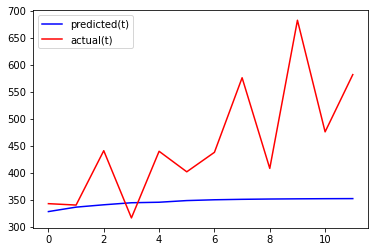

In [26]:
plt.plot(inv_pred[:,0],'b',label="predicted(t)")
plt.plot(inv_test[:,0],'r',label="actual(t)")
plt.legend()
plt.show()

In [27]:
# error calculation for train set
y_pred_tr = np.zeros((X_train.shape[0],n_months))
X_train_model = np.zeros((X_train[0].shape[0],X_train[0].shape[1]))
for i in range(X_train[0].shape[0]):
    for j in range(X_train[0].shape[1]):
        X_train_model[i][j] = X_train[0][i][j]

pred_train = []
print(X_train_model)
print(X_train[0])

[[-0.47858539]
 [-0.90545584]
 [-0.77323618]
 [-1.        ]
 [-0.7831882 ]]
[[-0.47858539]
 [-0.90545584]
 [-0.77323618]
 [-1.        ]
 [-0.7831882 ]]


In [28]:
for i in range(X_train.shape[0]):
    print("before X_test_model")
    print(X_train_model)
    X_train_model = X_train_model.reshape(1,window,n_features)

    pred_train = model.predict(X_train_model,batch_size=1)
    X_train_model.reshape(window,n_features)

    y_pred_tr[i]=np.array(pred_train.reshape(n_features,n_months))
#     print("\ny_pred")
#     print(y_pred_tr)

    
    X_train_model[0,:-1] = X_train_model[0,1:]
    X_train_model[0,-1] = pred_train[0,0]
        



before X_test_model
[[-0.47858539]
 [-0.90545584]
 [-0.77323618]
 [-1.        ]
 [-0.7831882 ]]
1/1 [==============================] - 0s 31ms/step
before X_test_model
[[[-0.90545584]
  [-0.77323618]
  [-1.        ]
  [-0.7831882 ]
  [-0.54468274]]]
1/1 [==============================] - 0s 31ms/step
before X_test_model
[[[-0.77323618]
  [-1.        ]
  [-0.7831882 ]
  [-0.54468274]
  [-0.65752208]]]
1/1 [==============================] - 0s 47ms/step
before X_test_model
[[[-1.        ]
  [-0.7831882 ]
  [-0.54468274]
  [-0.65752208]
  [-0.6582337 ]]]
1/1 [==============================] - 0s 31ms/step
before X_test_model
[[[-0.7831882 ]
  [-0.54468274]
  [-0.65752208]
  [-0.6582337 ]
  [-0.63720596]]]
1/1 [==============================] - 0s 31ms/step
before X_test_model
[[[-0.54468274]
  [-0.65752208]
  [-0.6582337 ]
  [-0.63720596]
  [-0.57178897]]]
1/1 [==============================] - 0s 47ms/step
before X_test_model
[[[-0.65752208]
  [-0.6582337 ]
  [-0.63720596]
  [-0.57178897

In [29]:
print(y_pred_tr)
print(y_train)

[[-0.54468274 -0.49976096]
 [-0.65752208 -0.64627337]
 [-0.6582337  -0.64719731]
 [-0.63720596 -0.61989456]
 [-0.57178897 -0.5349561 ]
 [-0.50905681 -0.45350361]
 [-0.46630204 -0.39799023]
 [-0.41627708 -0.33303696]
 [-0.3633543  -0.26432121]
 [-0.31384674 -0.2000398 ]
 [-0.27397677 -0.14827201]
 [-0.24405561 -0.10942189]
 [-0.22184755 -0.0805866 ]
 [-0.2059114  -0.05989483]
 [-0.19486843 -0.04555649]
 [-0.18742935 -0.03589746]
 [-0.18248457 -0.02947707]
 [-0.17921267 -0.02522878]]
[[-0.82512884 -0.60014217]
 [-0.60014217 -0.6260885 ]
 [-0.6260885  -0.73875955]
 [-0.73875955 -0.98720455]
 [-0.98720455 -0.22800782]
 [-0.22800782 -0.76328417]
 [-0.76328417 -0.73342811]
 [-0.73342811 -0.89266039]
 [-0.89266039 -0.6772703 ]
 [-0.6772703  -0.45263906]
 [-0.45263906 -0.74373556]
 [-0.74373556 -0.40394526]
 [-0.40394526 -0.62075706]
 [-0.62075706 -0.34494402]
 [-0.34494402 -0.39363782]
 [-0.39363782  0.07446241]
 [ 0.07446241 -0.48391683]
 [-0.48391683 -0.20739293]]


In [30]:
X_train = X_train.reshape(X_train.shape[0],window)

In [31]:

# inv_pred_tr = np.concatenate((y_pred_tr, X_train[:,-(window):]), axis=1)
# inv_pred_tr = scaler.inverse_transform(inv_pred_tr)
# inv_pred_tr = inv_pred_tr[:,0:n_months]

# inv_test_tr=np.concatenate((y_train,X_train[:,-(window):]),axis=1)
# inv_test_tr = scaler.inverse_transform(inv_test_tr)
# inv_test_tr = inv_test_tr[:,0:n_months]

# rmse = mean_squared_error(inv_pred_tr, inv_test_tr) ** (0.5)
# print('Test RMSE: %.3f' % rmse)

In [32]:
inv_pred_tr = np.concatenate((y_pred_tr, X_train), axis=1)
inv_pred_tr = inverse_transform(inv_pred_tr,min_data,max_data,min_range,max_range)
inv_pred_tr = inv_pred_tr[:,0:n_months]

inv_test_tr=np.concatenate((y_train,X_train),axis=1)
inv_test_tr = inverse_transform(inv_test_tr,min_data,max_data,min_range,max_range)
inv_test_tr = inv_test_tr[:,0:n_months]

rmse = mean_squared_error(inv_pred_tr, inv_test_tr) ** (0.5)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 91.985


In [33]:
print(inv_pred_tr)
print(inv_test_tr)

[[247.40351077 260.04225515]
 [215.65616214 218.82098607]
 [215.45594789 218.56103791]
 [221.37210361 226.24266438]
 [239.77717423 250.14010194]
 [257.42686747 273.05675969]
 [269.45592182 288.67544971]
 [283.53044332 306.95005154]
 [298.42026896 326.28322813]
 [312.3492205  344.36880115]
 [323.56663491 358.93367063]
 [331.98495304 369.86415014]
 [338.23319207 377.97696084]
 [342.71682819 383.79858958]
 [345.82376708 387.83268276]
 [347.91675137 390.55024863]
 [349.30796703 392.35662502]
 [350.22851403 393.55188177]]
[[168.5 231.8]
 [231.8 224.5]
 [224.5 192.8]
 [192.8 122.9]
 [122.9 336.5]
 [336.5 185.9]
 [185.9 194.3]
 [194.3 149.5]
 [149.5 210.1]
 [210.1 273.3]
 [273.3 191.4]
 [191.4 287. ]
 [287.  226. ]
 [226.  303.6]
 [303.6 289.9]
 [289.9 421.6]
 [421.6 264.5]
 [264.5 342.3]]


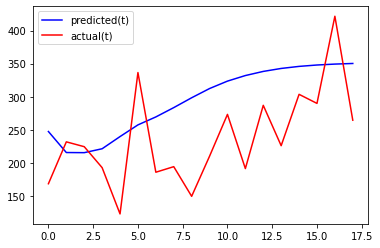

In [34]:
plt.plot(inv_pred_tr[:,0],'b',label="predicted(t)")
plt.plot(inv_test_tr[:,0],'r',label="actual(t)")
plt.legend()
plt.show()